# Physics Informed Neural Networks

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

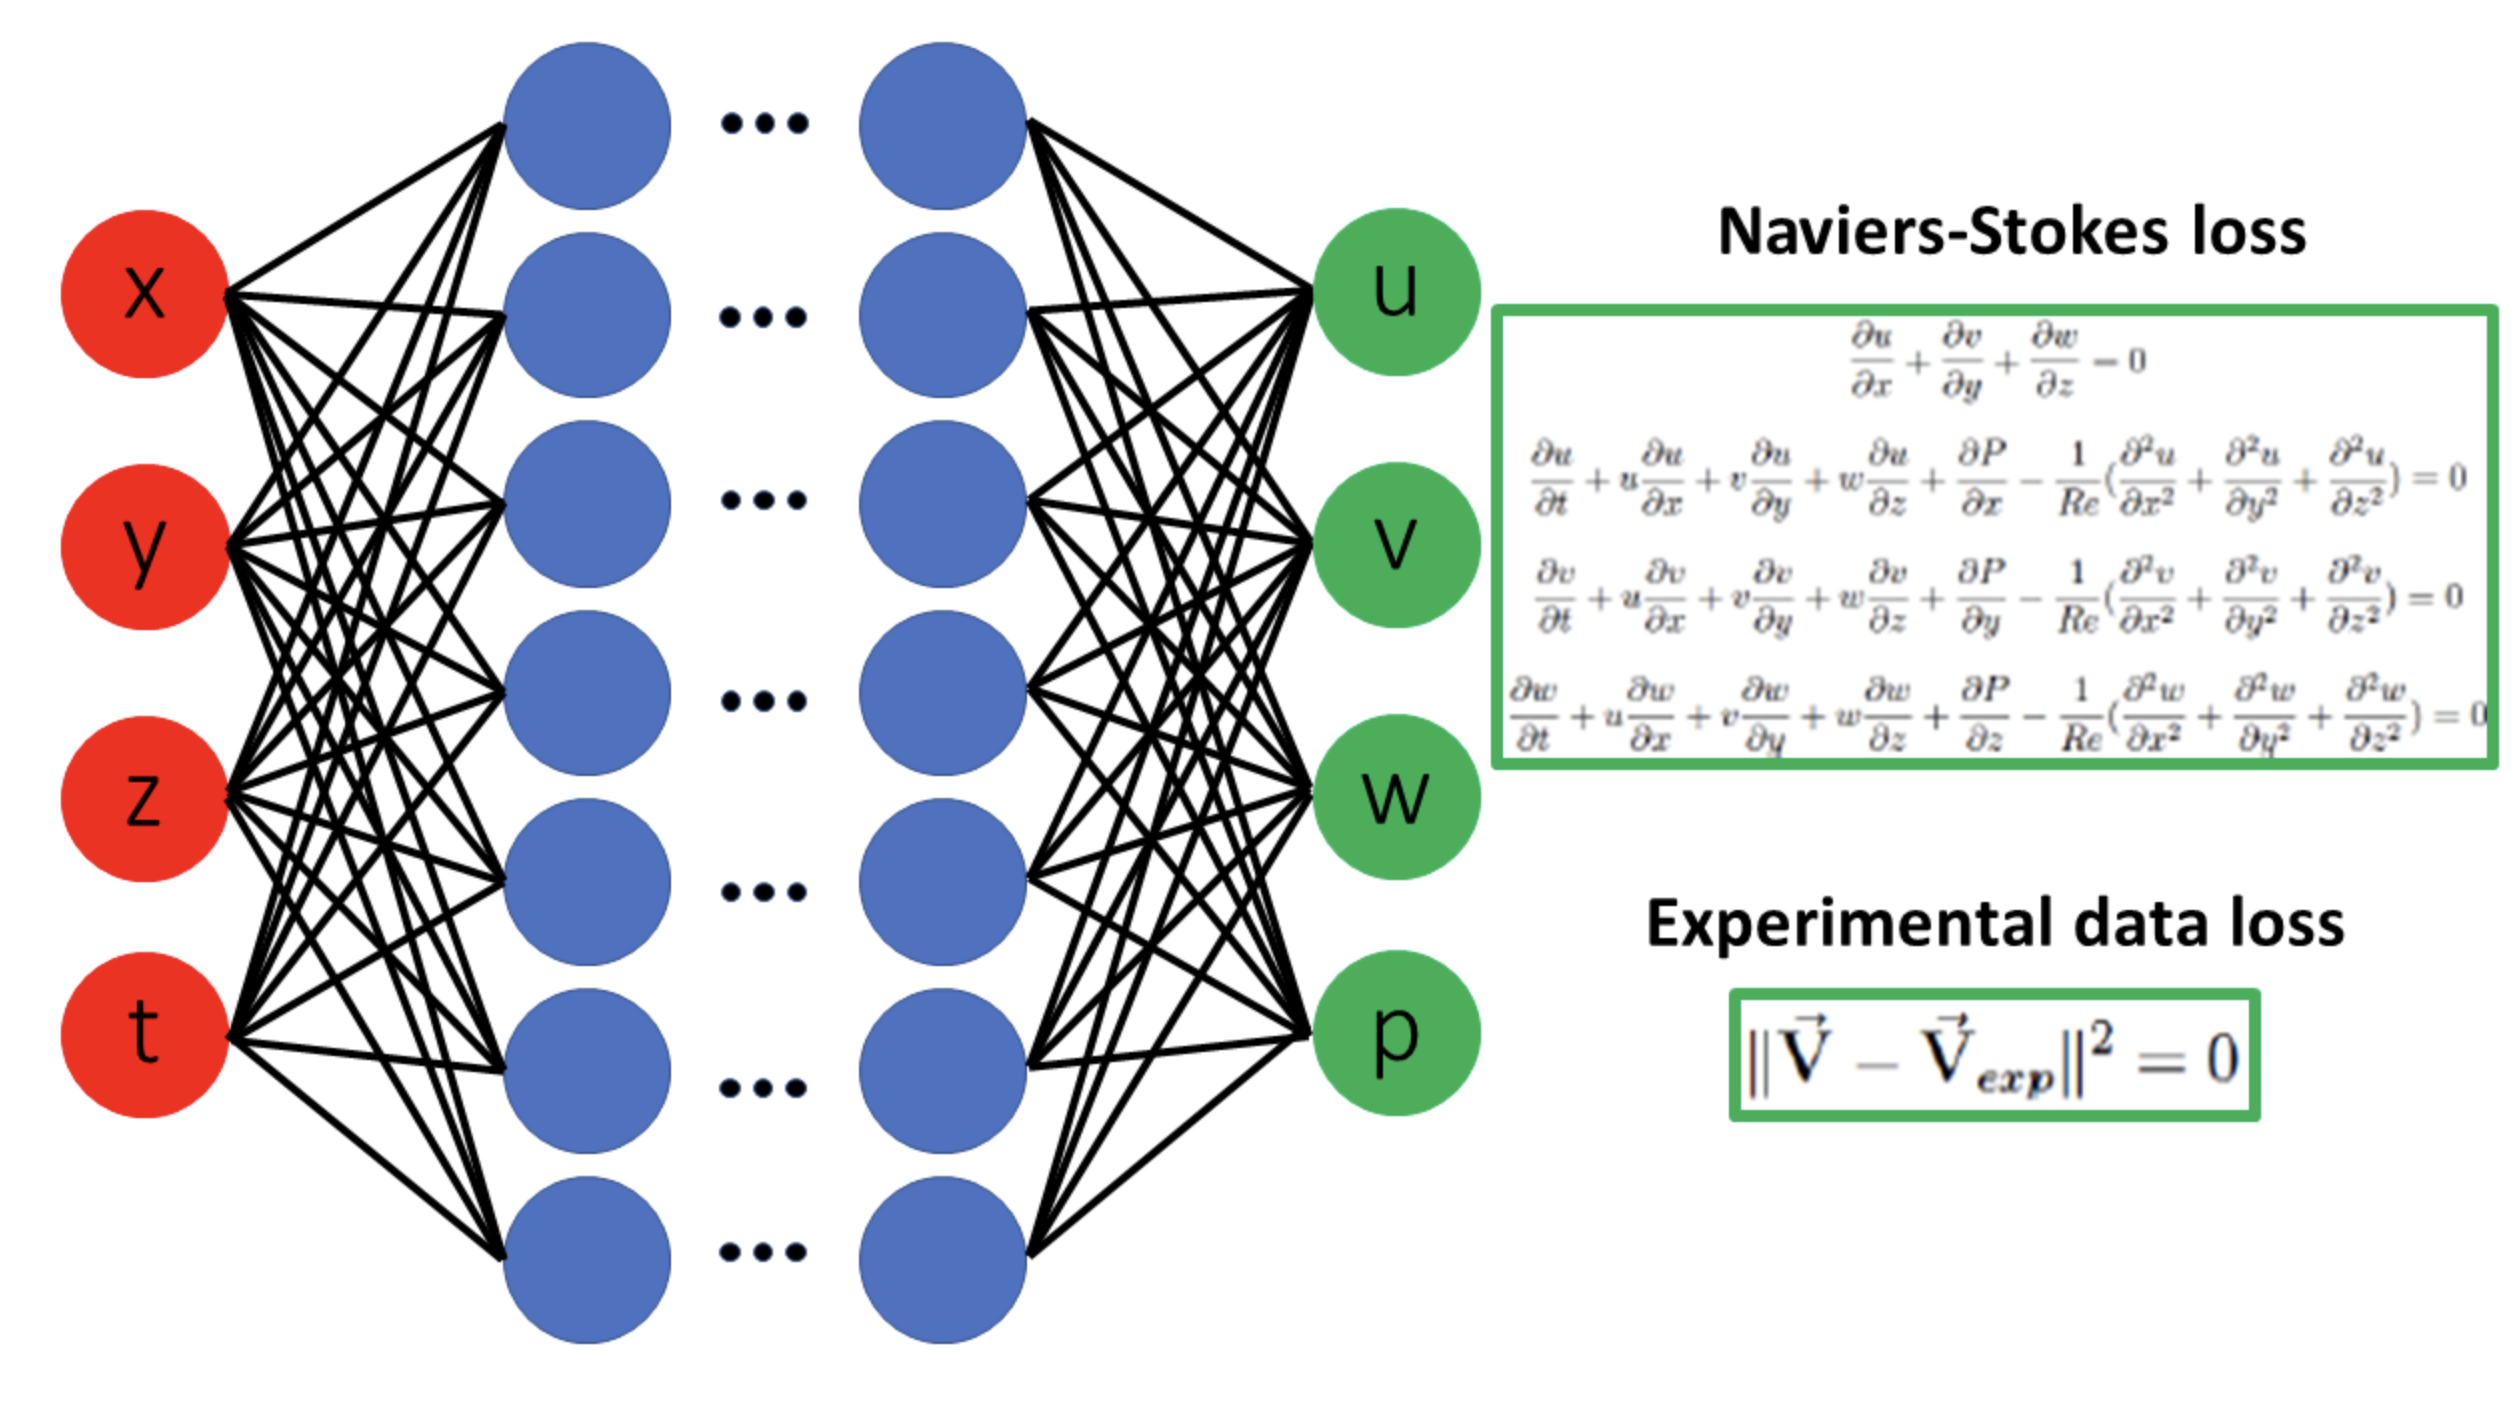

Physics-Informed Neural Networks (PINNs) are a type of universal function approximators that can embed the knowledge of any physical laws that govern a given data-set in the learning process, and can be described by partial differential equations (PDEs).


They overcome the low data availability of some biological and engineering systems that makes most state-of-the-art machine learning techniques lack robustness, rendering them ineffective in these scenarios.

The prior knowledge of general physical laws acts in the training of neural networks (NNs) as a regularization agent that limits the space of admissible solutions, increasing the correctness of the function approximation. This way, embedding this prior information into a neural network results in enhancing the information content of the available data, facilitating the learning algorithm to capture the right solution and to generalize well even with a low amount of training examples.

# Problem

$ 0 = \cfrac{\partial u}{\partial x} - 2 \cdot \cfrac{\partial u}{\partial t} - u \ \ \ \ \ x \in [0, 2], t \in [0, 1] $

$ u(x, 0) = 6 \cdot e^{-3x} \ \ \ \ \ x \in [0, 2] $ \\

$ \ $

The solution is: \\

$ \ $

$ u(x, t) = 6 \cdot e^{-(3x + 2t)} $

In [1]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

# 1. Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import time
import math
import torch
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from PIL import Image, ImageOps
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import image as mp_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 2. Creation of Neural Network

In [4]:
class Net(nn.Module):

    def __init__(self):

        super(Net, self).__init__()

        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)

        self.output_layer = nn.Linear(5,1)


    def forward(self, x,t):

        inputs = torch.cat([x, t], axis=1)

        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))

        output = self.output_layer(layer5_out)

        return output

In [5]:
def f(x, t, net):

    u = net(x, t)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    pde = u_x - 2*u_t - u

    return pde

### Start time of execution

In [6]:
start = time.time()

# 3. Preparation of Training

In [7]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [8]:
net = Net()
net = net.to(device)

mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

# 4. Training

The loss is the sum of the error on boundary conditions and the PDE.

In [9]:
# Boundary Conditions

x_bc = np.random.uniform(low = 0.0, high = 2.0, size = (500, 1))
t_bc = np.zeros((500, 1))
u_bc = 6*np.exp(-3*x_bc)

# Space and Temporal Conditions

x_space = np.random.uniform(low = 0.0, high = 2.0, size = (500, 1))
t_temp = np.random.uniform(low = 0.0, high = 1.0, size = (500, 1))

func = 6*np.exp(-3*x_space - 2*t_temp)
all_zeros = np.zeros((500, 1))

In [10]:
pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

pt_x_space = Variable(torch.from_numpy(x_space).float(), requires_grad = True).to(device)
pt_t_temp = Variable(torch.from_numpy(t_temp).float(), requires_grad = True).to(device)
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad = False).to(device)

func = Variable(torch.from_numpy(func).float(), requires_grad = False).to(device)

In [11]:
# Hyperparameters

number_of_epochs = 20_000

all_epochs = []
all_mse_train = []
all_mse_val = []

In [12]:
start_iter = time.time()

In [13]:
for epoch in range(1, number_of_epochs + 1):

  optimizer.zero_grad()

  # Loss based on boundary conditions

  net_bc_out = net(pt_x_bc, pt_t_bc)
  mse_bc = mse_cost_function(net_bc_out, pt_u_bc)

  # PDE

  f_out = f(pt_x_space, pt_t_temp, net)
  mse_f = mse_cost_function(f_out, pt_all_zeros)

  # Validation loss

  val_loss = mse_cost_function(net(pt_x_space, pt_t_temp), func)

  # Combining the loss functions

  loss = mse_bc + mse_f

  loss.backward()
  optimizer.step()

  all_epochs.append(epoch)
  all_mse_train.append(loss.item())
  all_mse_val.append(val_loss.item())

  if (epoch % 1_000) == 0:

    print('Epoch:', epoch)

    end_iter = time.time()
    print(print_time_execution(start_iter, end_iter, 'Over 1_000 iterations'))
    start_iter = time.time()
    print('-'*70)

all_epochs = np.array(all_epochs)
all_mse_train = np.array(all_mse_train)
all_mse_val = np.array(all_mse_val)

Epoch: 1000
Over 1_000 iterations it takes 0 hours, 0 mins and 8 segs.
----------------------------------------------------------------------
Epoch: 2000
Over 1_000 iterations it takes 0 hours, 0 mins and 11 segs.
----------------------------------------------------------------------
Epoch: 3000
Over 1_000 iterations it takes 0 hours, 0 mins and 6 segs.
----------------------------------------------------------------------
Epoch: 4000
Over 1_000 iterations it takes 0 hours, 0 mins and 6 segs.
----------------------------------------------------------------------
Epoch: 5000
Over 1_000 iterations it takes 0 hours, 0 mins and 5 segs.
----------------------------------------------------------------------
Epoch: 6000
Over 1_000 iterations it takes 0 hours, 0 mins and 6 segs.
----------------------------------------------------------------------
Epoch: 7000
Over 1_000 iterations it takes 0 hours, 0 mins and 5 segs.
----------------------------------------------------------------------
Epoch

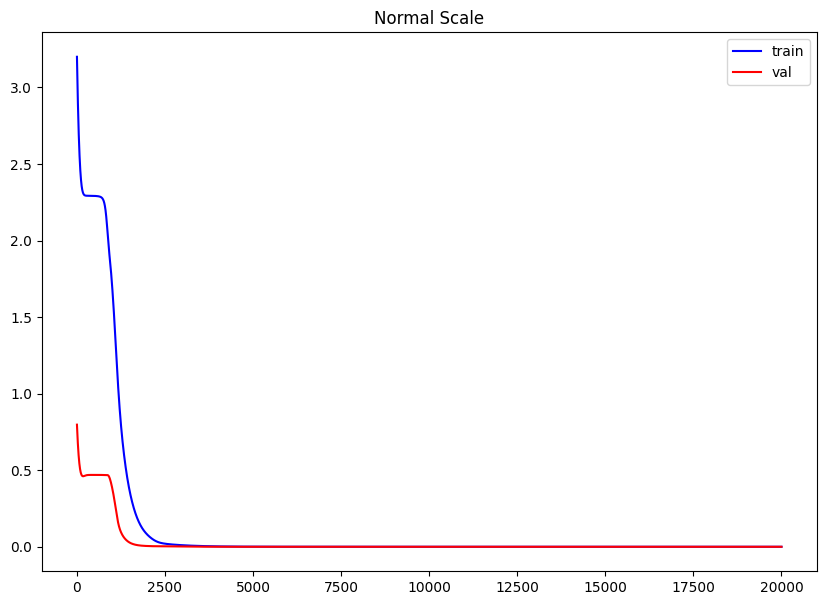

In [14]:
plt.figure(figsize = (10, 7))
plt.title('Normal Scale')
plt.plot(all_epochs, all_mse_train, color = 'blue', label = 'train')
plt.plot(all_epochs, all_mse_val, color = 'red', label = 'val')
plt.legend()
plt.show()

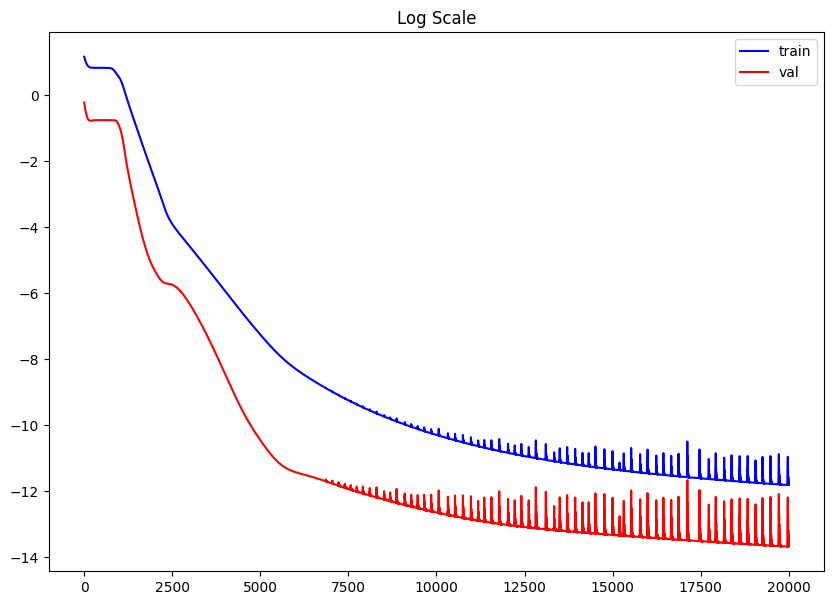

In [15]:
plt.figure(figsize = (10, 7))
plt.title('Log Scale')
plt.plot(all_epochs, np.log(all_mse_train), color = 'blue', label = 'train')
plt.plot(all_epochs, np.log(all_mse_val), color = 'red', label = 'val')
plt.legend()
plt.show()

# 5. Testing

In [16]:
out_test = net(pt_x_space, pt_t_temp)
test_loss = mse_cost_function(out_test, func)

print('Test Loss:', test_loss.item())
print('Test Log Loss:', math.log(test_loss.item()))

Test Loss: 1.1429300457166391e-06
Test Log Loss: -13.681915377372189


# 6. Plot

In [17]:
dim = 500

In [18]:
x_space = np.random.uniform(low = 0.0, high = 2.0, size = (dim, 1))
t_temp = np.random.uniform(low = 0.0, high = 1.0, size = (dim, 1))

In [19]:
x_plot, t_plot = np.meshgrid(x_space, t_temp)

In [20]:
u_plot = np.array([net(torch.Tensor(x_plot[i].reshape((dim, 1))).to(device), torch.Tensor(t_plot[i].reshape((dim, 1))).to(device)).detach().cpu().numpy() for i in range(dim)])

In [21]:
u_plot = u_plot.reshape((dim, dim))

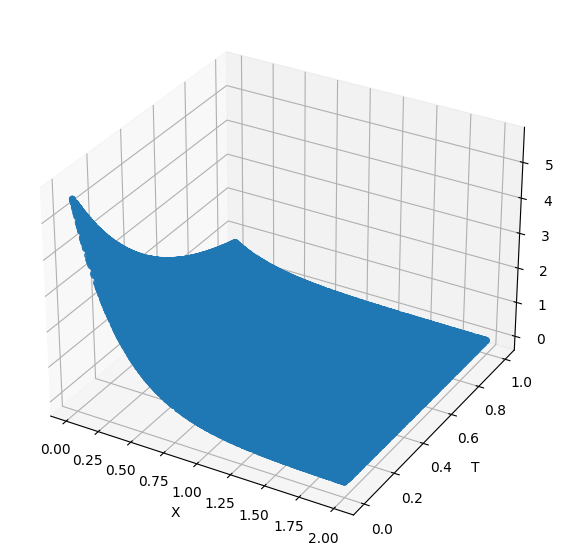

In [22]:
plt.figure(figsize = (10, 7))
ax = plt.axes(projection = '3d')

ax.scatter(x_plot, t_plot, u_plot, linewidth = 0.5)

ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('Z')

plt.show()

### End time of execution

In [23]:
end = time.time()

In [24]:
print(print_time_execution(start, end, 'this notebook'))

this notebook it takes 0 hours, 2 mins and 19 segs.
